In [282]:
import collections
import sys
from pathlib import Path
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage import exposure

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=34)
import math
import networkx as nx 
from sklearn.neighbors import NearestNeighbors
from PIL import Image 
from skimage import measure 
from sklearn.metrics.pairwise import paired_distances


In [283]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [285]:
from config import *
import my_io as io

In [286]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split('\\')[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [287]:
dataset = datasets[8]

# Read image 

In [288]:
imgs = []
markers = []
masks = []

for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
        for name in sorted(filenames):
            if 'tiff' in name and dataset in name:
                img = cv2.imread(os.path.join(dirpath,name),flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))
                imgs.append(img)
                markers.append(name.split('_')[1].split('.')[0])

for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
    for name in sorted(filenames):
        if 'tiff' in name and dataset in name:        
            img = cv2.imread(os.path.join(dirpath,name),0)
            masks.append(img)

# Read cell mask image 
for (dirpath, dirnames, filenames) in os.walk(data_cell_mask):
    for name in sorted(filenames):
        if  'tiff' in name and dataset in name:
            cell_mask = np.array(Image.open(os.path.join(dirpath,name)))
            

# Spatial reference

In [291]:
n = 5
neigh = NearestNeighbors(n_neighbors=n)

In [292]:
cell_centroid_marker = {}
cell_count_marker = {}

for i, mask in enumerate(masks):
    res = cv2.bitwise_and(cell_mask,cell_mask, mask=mask)
    prop = measure.regionprops_table(res, properties = ['centroid', 'area'])
    # Read points location
    cell_centroid_marker[i] = np.vstack((prop['centroid-0'], prop['centroid-1'])).T
    cell_count_marker[i] = len(prop['centroid-0'])

In [293]:
marker_distance_nn = {}
for i in range(len(cell_centroid_marker)):
    marker_distance_nn[markers[i]] = {}
    X = cell_centroid_marker[i]
    neigh.fit(X)
    for j in range(len(cell_centroid_marker)):
        if i == j:
            continue
        Y = cell_centroid_marker[j]
        # fit the NN 
        neighbors = neigh.kneighbors(Y,return_distance=False)
        # Get the n neirest neighbors position per cell
        n_distance = X[neighbors]
        #Computes the distances between (X[0], Y[0]), (X[1], Y[1]) ....
        distance = paired_distances(Y, n_distance.mean(axis = 1))
        marker_distance_nn[markers[i]][markers[j]] = {"weight": 1/distance.mean()}

In [294]:
# Sort by distance and keep top 5
top_n = 6
marker_distance_nn_sorted = {}
for key, values in marker_distance_nn.items():
    marker_distance_nn_sorted[key] = dict(sorted(values.items(), key=lambda x: x[1]['weight'], reverse=True)[:top_n])

In [295]:
fixed_nodes = ['CD3', 'CD4', 'CD8a', 'CD20', 'DNA1', 'DNA2', 'Histone3']
fixed_pos = {
    'CD3': [0,12],
    'CD4': [12,12],
    'CD8a': [4,16],
    'CD20': [8,16],
    'DNA1': [0, -8],
    'DNA2': [12, -8],
    'Histone3': [6, -10],
}

color_node = []
for marker in markers:
    if marker in fixed_nodes:
        color_node.append([255/255, 182/255, 193/255, 1])
    else:
        color_node.append([65/255, 105/255, 225/255, 1])

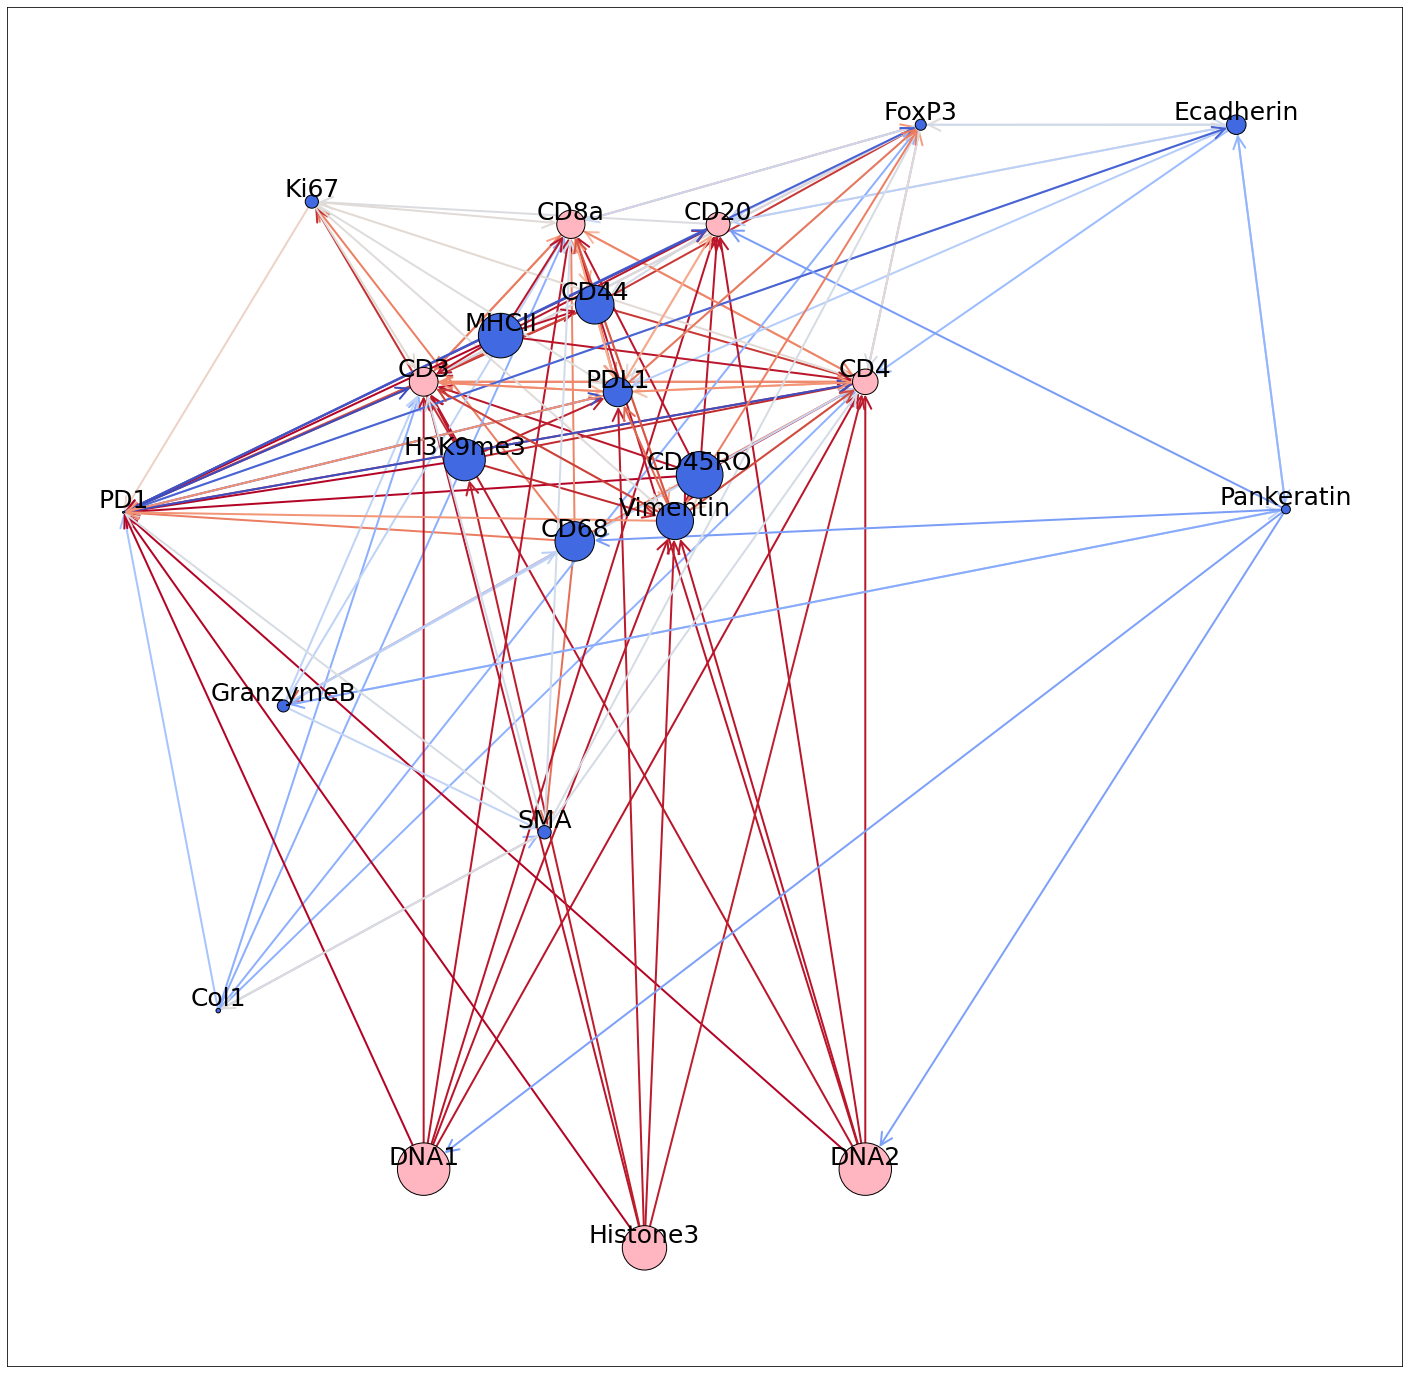

In [296]:
G = nx.from_dict_of_dicts(marker_distance_nn_sorted, nx.DiGraph)

edges = G.edges()
weights = np.array([G[u][v]['weight'] for u, v in edges])
edge_c = np.log(weights)
size = np.array(list(cell_count_marker.values()))
size = size/20
pos = nx.spring_layout(G, k=3.0, iterations=5, pos=fixed_pos, fixed=fixed_nodes, seed=0)

fig, ax = plt.subplots(figsize=(25, 25))

nodes = nx.draw_networkx_nodes(G, pos, 
                               node_size=size, 
                               node_color=color_node, 
                              edgecolors='black')
labels = nx.draw_networkx_labels(G, pos,
                               font_size=25, 
                               font_color='black',
                                 verticalalignment='bottom'
                                )
edges = nx.draw_networkx_edges(G, pos, 
                               node_size=size, 
                               arrowstyle="->",
                               arrowsize=30,
                               width=2, 
                               edge_color=edge_c, 
                               edge_cmap=plt.cm.coolwarm)

x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()
fig.savefig(data_figure / 'clusters' / f'{dataset}_spatial_reference.png', bbox_inches='tight')